---------------------------------------------------------------------------------------
## Import library

In [26]:
import numpy as np
import pandas as pd

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Import Dataset

In [18]:
data = pd.read_csv('/content/fer2013.csv')
data.shape

(35887, 3)

In [19]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [20]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [21]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


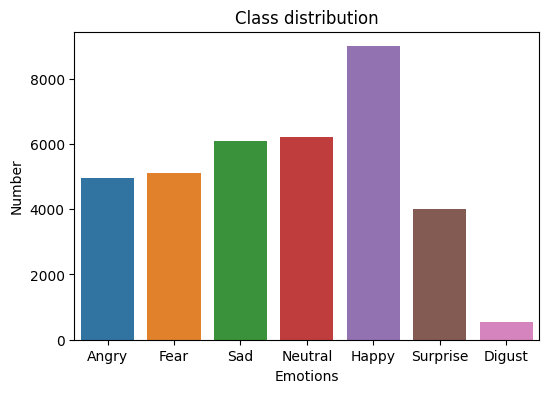

In [22]:

plt.figure(figsize=(6, 4))
sns.barplot(x=emotion_counts.emotion, y=emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=10)
plt.xlabel('Emotions', fontsize=10)
plt.show()

<ipython-input-23-483c62a7888b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


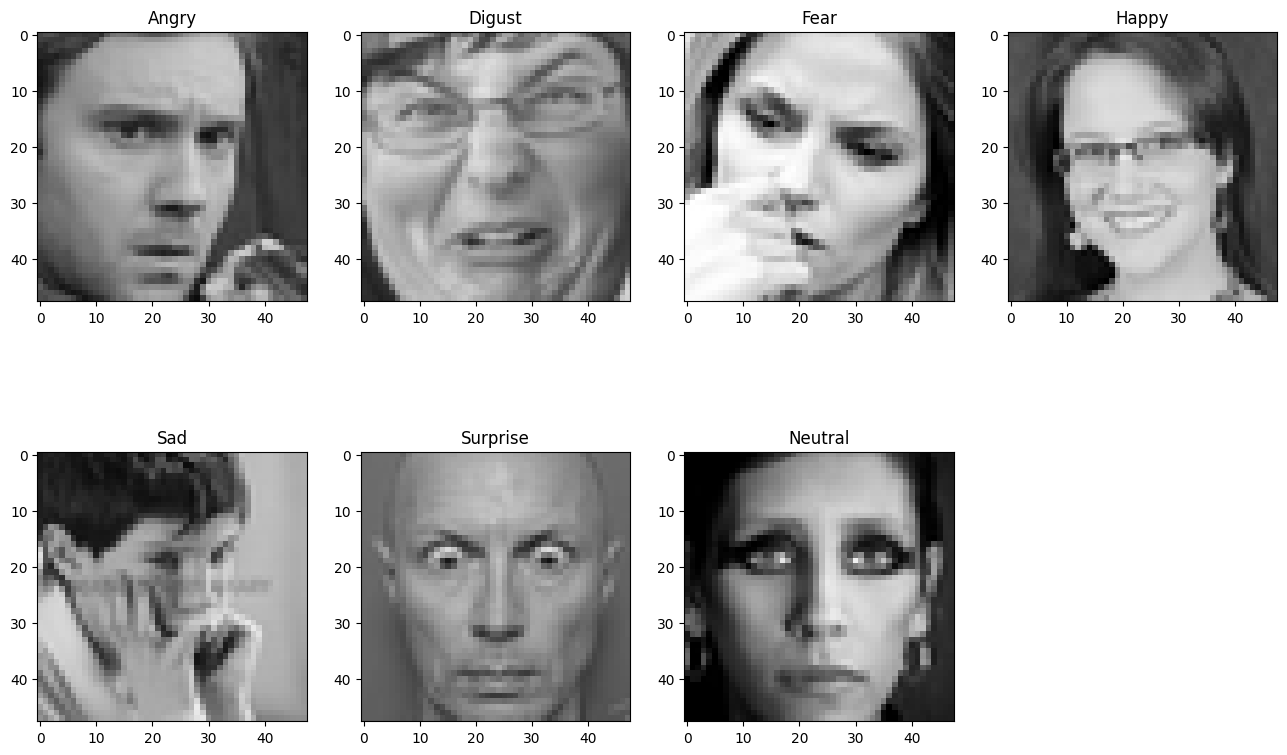

In [23]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

----------------------------------------------------------------------------------
## Pre-processing data


In [24]:
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


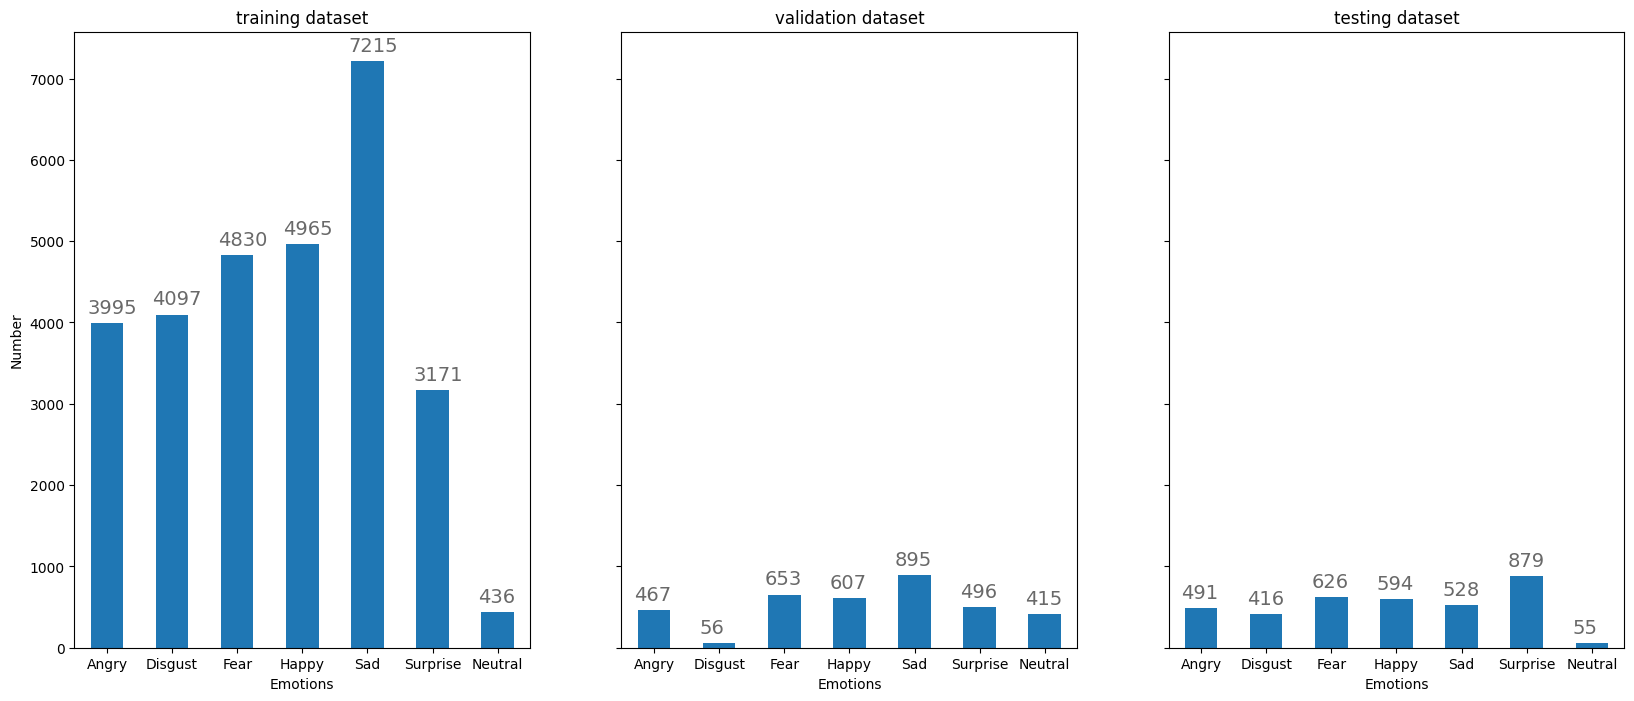

In [25]:
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
  df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
  axe.set_xticklabels(emotion_labels)
  axe.set_xlabel("Emotions")
  axe.set_ylabel("Number")
  axe.set_title(title)

  for i in axe.patches:
      axe.text(i.get_x()-.05, i.get_height()+120, \
              str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                  rotation=0)


fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'training dataset')
setup_axe(axes[1],data_val,'validation dataset')
setup_axe(axes[2],data_test,'testing dataset')
plt.show()

In [ ]:
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [ ]:

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0
    data_Y = to_categorical(df['emotion'], num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y


train_X, train_Y = CRNO(data_train, "train")
val_X, val_Y     = CRNO(data_val, "val")
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


----------------------------------------------------------------------------------
## Build CNN Model


In [ ]:
model = Sequential()

#Layer module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Layer module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Layer module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten layer
model.add(Flatten())

#dense layer 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense layer 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense layer 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)       0         
__________

In [ ]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2,
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50
 - 37s - loss: 1.7037 - acc: 0.3242 - val_loss: 1.6681 - val_acc: 0.3589
Epoch 2/50
 - 30s - loss: 1.4228 - acc: 0.4470 - val_loss: 1.4414 - val_acc: 0.4450
Epoch 3/50
 - 30s - loss: 1.2625 - acc: 0.5140 - val_loss: 1.5380 - val_acc: 0.4606
Epoch 4/50
 - 30s - loss: 1.1799 - acc: 0.5468 - val_loss: 1.3059 - val_acc: 0.5102
Epoch 5/50
 - 30s - loss: 1.1281 - acc: 0.5658 - val_loss: 1.1986 - val_acc: 0.5366
Epoch 6/50
 - 30s - loss: 1.0889 - acc: 0.5892 - val_loss: 1.2567 - val_acc: 0.5308
Epoch 7/50
 - 30s - loss: 1.0636 - acc: 0.5970 - val_loss: 1.0932 - val_acc: 0.5913
Epoch 8/50
 - 30s - loss: 1.0317 - acc: 0.6090 - val_loss: 1.3399 - val_acc: 0.4912
Epoch 9/50
 - 30s - loss: 1.0131 - acc: 0.6192 - val_loss: 1.0130 - val_acc: 0.6222
Epoch 10/50
 - 30s - loss: 0.9876 - acc: 0.6263 - val_loss: 1.1529 - val_acc: 0.5857
Epoch 11/50
 - 30s - loss: 0.9707 - acc: 0.6336 - val_loss: 1.1352 - val_acc: 0.5756
Epoch 12/50
 - 30s - loss: 0.9510 - acc: 0.6380 - val_loss: 1.1439 - val_a

## plot model accuaracy and loss



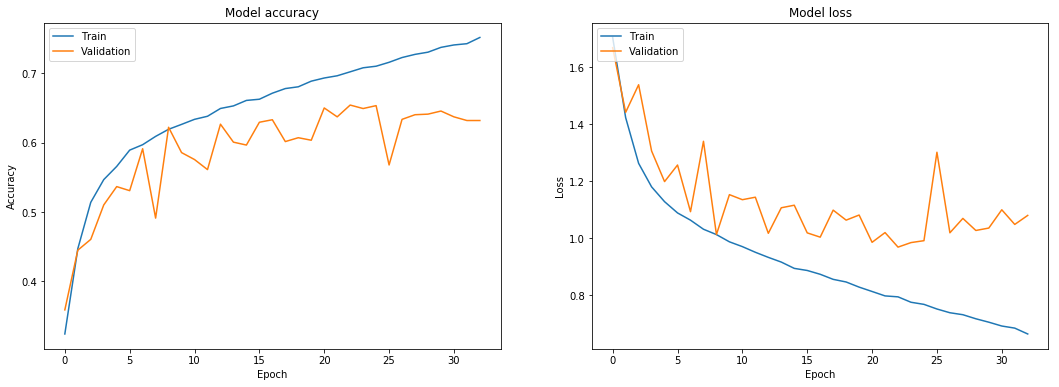

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

## accuracy test model

In [ ]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6662


##  Confusion Matrix




In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

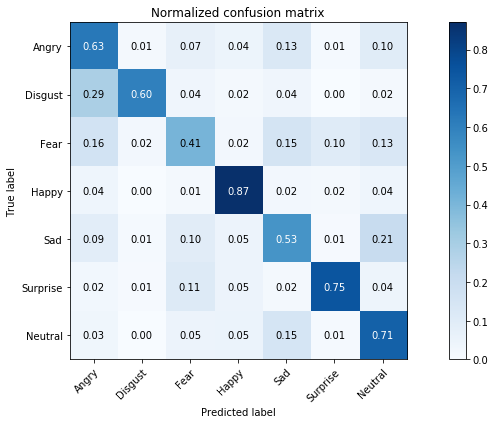

In [ ]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()